In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
from IPython.display import display
from sklearn.exceptions import ConvergenceWarning

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.max_colwidth", None)

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv("kadınlar_icin_diabetes.csv")

df.head()

Saving kadınlar_icin_diabetes.csv to kadınlar_icin_diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    display(dataframe.head(head))

    print("##################### Tail #####################")
    display(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    display(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def cat_summary(dataframe, col_name, plot=False):# kategorik değişkenin sınıf frekansını ve oranını veriyor
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False): # temel sayısal istatistikleri hesaplar
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col): # bağımlı değişkeni sayısal bir değişkenle özetlemek için
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):# bağımlı değişkeni kategorik değişkene göre özetliyor
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols): # sayısal değişkenlerin korelasyon matrisini hesaplıyor
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [4]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##################### Tail #####################


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


##################### NA #####################
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
##################### Quantiles #####################


,0.00,0.05,0.50,0.95,0.99,1.00
Pregnancies,0.000,0.00000,3.0000,10.00000,13.00000,17.00
Glucose,0.000,79.00000,117.0000,181.00000,196.00000,199.00
BloodPressure,0.000,38.70000,72.0000,90.00000,106.00000,122.00
SkinThickness,0.000,0.00000,23.0000,44.00000,51.33000,99.00
Insulin,0.000,0.00000,30.5000,293.00000,519.90000,846.00
BMI,0.000,21.80000,32.0000,44.39500,50.75900,67.10
DiabetesPedigreeFunction,0.078,0.14035,0.3725,1.13285,1.69833,2.42
Age,21.000,21.00000,29.0000,58.00000,67.00000,81.00
Outcome,0.000,0.00000,0.0000,1.00000,1.00000,1.00


### Outcome değişkenini gözlemleyelim

In [5]:
df.Outcome.unique() # ideal formda

array([1, 0])

In [6]:
cat_summary(df, "Outcome")

         Outcome      Ratio
Outcome                    
0            500  65.104167
1            268  34.895833
##########################################


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

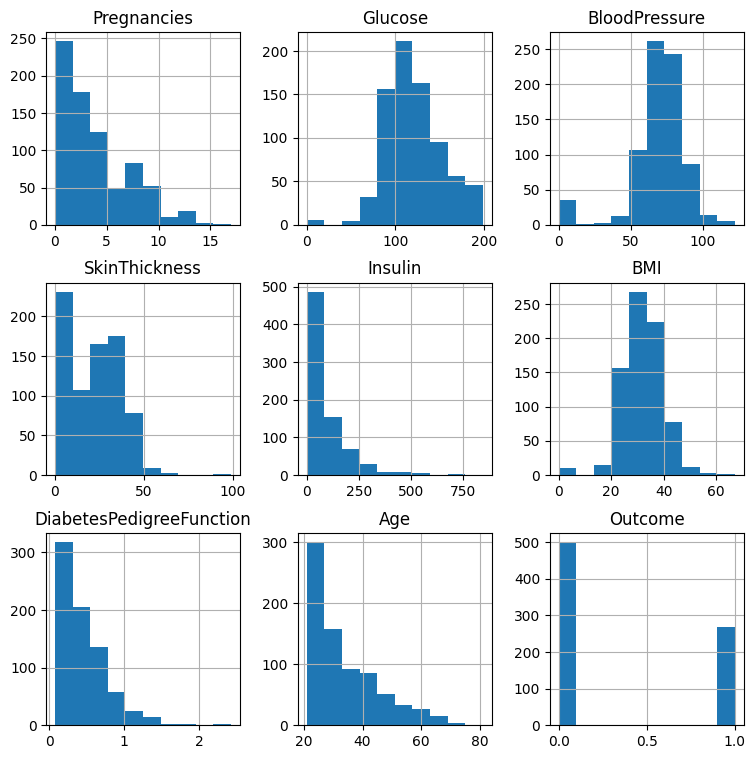

In [7]:
df.hist(figsize = (9,9))

In [8]:
num_summary(df, df.columns)

                          count        mean         std     min        5%     10%      20%      30%       40%       50%       60%       70%      80%       90%        95%        99%     max
Pregnancies               768.0    3.845052    3.369578   0.000   0.00000   0.000   1.0000    1.000    2.0000    3.0000    4.0000    5.0000    7.000    9.0000   10.00000   13.00000   17.00
Glucose                   768.0  120.894531   31.972618   0.000  79.00000  85.000  95.0000  102.000  109.0000  117.0000  125.0000  134.0000  147.000  167.0000  181.00000  196.00000  199.00
BloodPressure             768.0   69.105469   19.355807   0.000  38.70000  54.000  60.0000   64.000   68.0000   72.0000   74.0000   78.0000   82.000   88.0000   90.00000  106.00000  122.00
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   0.000   0.0000    8.200   18.0000   23.0000   27.0000   31.0000   35.000   40.0000   44.00000   51.33000   99.00
Insulin                   768.0   79.799479  115.244002

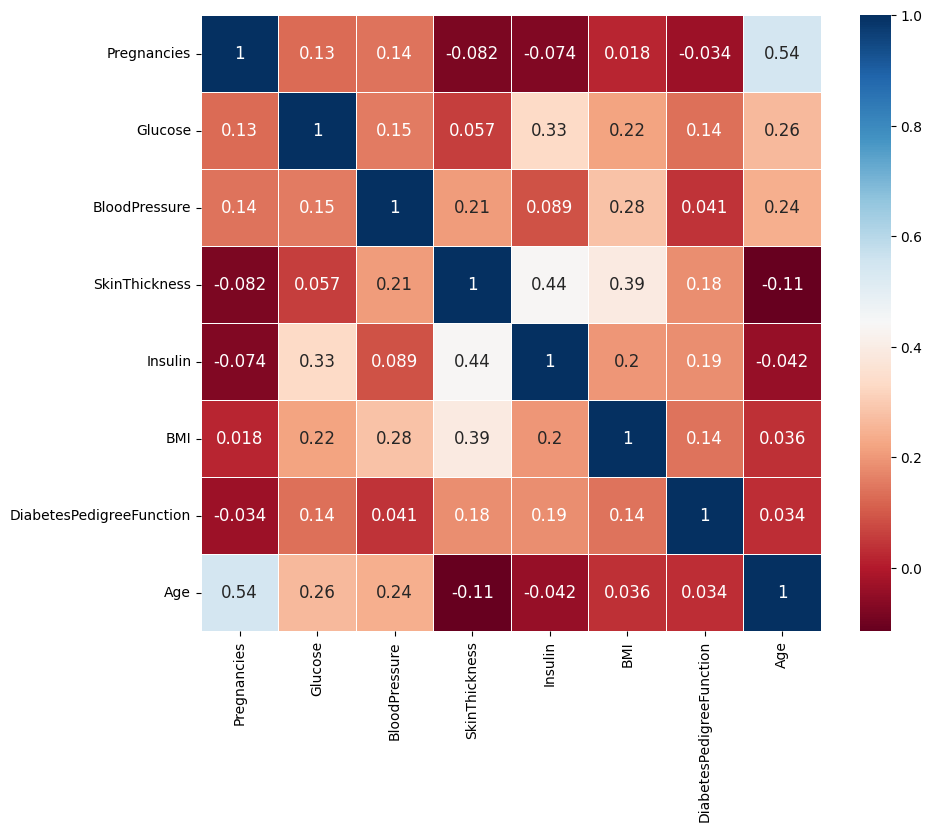

In [9]:
cols_no_outcome = [col for col in df.columns if col != 'Outcome']  # 'Outcome' sütununu çıkar
correlation_matrix(df, cols_no_outcome)


### eksik değerler

In [10]:
df.isnull().sum() # eksik değerleri 0 ile değiştirmeyi tercih etmişler

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

for col in num_cols: # eksik değerleri medyan ile tamamlamayı seçtim
    df[col] = df[col].replace(0, df[col].median())

print(df[(df['Glucose'] == 0) | (df['BloodPressure'] == 0) | (df['Insulin'] == 0)])  # 0 değeri kaldımı görmek için


Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


In [12]:
num_summary(df, num_cols)

                          count        mean         std     min        5%     10%      20%      30%       40%       50%       60%       70%      80%       90%        95%        99%     max
Pregnancies               768.0    4.278646    3.021516   1.000   1.00000   1.000   2.0000    2.000    3.0000    3.0000    4.0000    5.0000    7.000    9.0000   10.00000   13.00000   17.00
Glucose                   768.0  121.656250   30.438286  44.000  80.00000  86.700  95.0000  102.100  109.0000  117.0000  125.0000  134.0000  147.000  167.0000  181.00000  196.00000  199.00
BloodPressure             768.0   72.386719   12.096642  24.000  52.00000  58.000  62.0000   66.000   70.0000   72.0000   74.0000   78.0000   82.000   88.0000   90.00000  106.00000  122.00
SkinThickness             768.0   27.334635    9.229014   7.000  14.35000  18.000  23.0000   23.000   23.0000   23.0000   27.0000   31.0000   35.000   40.0000   44.00000   51.33000   99.00
Insulin                   768.0   94.652344  105.547598

In [13]:
def outlier_thresholds(dataframe, col_name, q1=0.1, q3=0.9): # aykırı değer tanımı
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable): # alt üst limitlerle aykırı değeri kontrol et
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.1, q3=0.9): # aykırı değer varmı
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [14]:
for col in df.columns:
    if check_outlier(df, col):
        print(f"{col} sütununda aykırı değer bulundu.")
    else:
        print(f"{col} sütununda aykırı değer bulunmadı.")

Pregnancies sütununda aykırı değer bulunmadı.
Glucose sütununda aykırı değer bulunmadı.
BloodPressure sütununda aykırı değer bulunmadı.
SkinThickness sütununda aykırı değer bulundu.
Insulin sütununda aykırı değer bulundu.
BMI sütununda aykırı değer bulunmadı.
DiabetesPedigreeFunction sütununda aykırı değer bulundu.
Age sütununda aykırı değer bulunmadı.
Outcome sütununda aykırı değer bulunmadı.


In [15]:
for col in num_cols:
    replace_with_thresholds(df, col)

### feature engineering

In [16]:
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

df["NewBMI"] = NewBMI

df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]
df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

df.loc[(df.Outcome == 1) & (df.Insulin <= 100) , "Insulin"] = 70
df.loc[(df.Outcome == 0) & (df.Insulin >= 200 ) , "Insulin"] = 200
df.loc[(df.Outcome == 0) & (df.Glucose >= 175 ) , "Glucose"] = 175
df.loc[(df.Outcome == 1) & (df.Glucose <= 80 ) , "Glucose"] = 80
df.loc[(df.Outcome == 0) & (df.Pregnancies >= 13 ) , "Pregnancies"] = 13
df.loc[(df.Outcome == 0) & (df.DiabetesPedigreeFunction >= 1.3 ) , "DiabetesPedigreeFunction"] = 1.3
df.loc[(df.Outcome == 0) & (df.BMI >= 50 ) , "BMI"] = 50
df["NEW_g_p"] = (df.Glucose * df.Pregnancies)
df["NEW_i_g"] = (df.Glucose * df.Insulin)

df['New_Glucose'] = pd.cut(x=df['Glucose'], bins=[0,74,99,139,200],labels = ["Low","Normal","Overweight","High"])


In [17]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"


df = df.assign(NewInsulinScore=df.apply(set_insulin, axis=1))

In [18]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NEW_g_p,NEW_i_g,New_Glucose,NewInsulinScore
0,6,148.0,72,35,70.0,33.6,0.627,50.0,1,Obesity 1,888.0,10360.0,High,Normal
1,1,85.0,66,29,30.5,26.6,0.351,31.0,0,Overweight,85.0,2592.5,Normal,Normal
2,8,183.0,64,23,70.0,23.3,0.672,32.0,1,Normal,1464.0,12810.0,High,Normal
3,1,89.0,66,23,94.0,28.1,0.167,21.0,0,Overweight,89.0,8366.0,Normal,Normal
4,3,137.0,40,35,168.0,43.1,1.949,33.0,1,Obesity 3,411.0,23016.0,Overweight,Abnormal


### one hot encoding

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    float64 
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    float64 
 8   Outcome                   768 non-null    int64   
 9   NewBMI                    768 non-null    category
 10  NEW_g_p                   768 non-null    float64 
 11  NEW_i_g                   768 non-null    float64 
 12  New_Glucose               768 non-null    category
 13  NewInsulinScore           768 non-null    object  

In [20]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

cat_cols = [col for col in cat_cols if col != 'Outcome']

df[cat_cols].head()

,NewInsulinScore,NewBMI,New_Glucose
0,Normal,Obesity 1,High
1,Normal,Overweight,Normal
2,Normal,Normal,High
3,Normal,Overweight,Normal
4,Abnormal,Obesity 3,Overweight


In [21]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False): # adı üstüne
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols)

df = df.replace({True: 1, False: 0})

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_g_p,NEW_i_g,NewInsulinScore_Abnormal,NewInsulinScore_Normal,NewBMI_Normal,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,New_Glucose_Low,New_Glucose_Normal,New_Glucose_Overweight,New_Glucose_High
0,6,148.0,72,35,70.0,33.6,0.627,50.0,1,888.0,10360.0,0,1,0,1,0,0,0,0,0,0,0,1
1,1,85.0,66,29,30.5,26.6,0.351,31.0,0,85.0,2592.5,0,1,0,0,0,0,1,0,0,1,0,0
2,8,183.0,64,23,70.0,23.3,0.672,32.0,1,1464.0,12810.0,0,1,1,0,0,0,0,0,0,0,0,1
3,1,89.0,66,23,94.0,28.1,0.167,21.0,0,89.0,8366.0,0,1,0,0,0,0,1,0,0,1,0,0
4,3,137.0,40,35,168.0,43.1,1.949,33.0,1,411.0,23016.0,1,0,0,0,0,1,0,0,0,0,1,0


In [22]:
X = df.drop(["Outcome"], axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
scaler = StandardScaler()

# Sadece sayısal kolonları seçip standardize ediyoruz
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols]) # sadece test verisini transform ediyoruz

X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NEW_g_p,NEW_i_g,NewInsulinScore_Abnormal,NewInsulinScore_Normal,NewBMI_Normal,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,New_Glucose_Low,New_Glucose_Normal,New_Glucose_Overweight,New_Glucose_High
44,0.928721,1.255386,-0.663676,-0.475346,-0.795055,-0.741771,-0.576058,0.561034,1.389430,-0.573383,0,1,0,0,0,0,1,0,0,0,0,1
672,1.936203,-1.797912,2.760669,-0.475346,-0.566005,0.452623,-0.605248,1.153060,0.359153,-0.685996,0,1,0,0,1,0,0,0,1,0,0,0
700,-0.750415,0.013935,0.314708,-0.032123,1.303536,0.511605,0.036917,-0.623019,-0.678263,0.877444,1,0,0,0,1,0,0,0,0,0,1,0
630,0.928721,-0.254487,-0.663676,-0.475346,-0.306003,-0.741771,0.844488,0.053583,0.639921,-0.341071,0,1,0,0,0,0,1,0,0,0,1,0
81,-0.750415,-1.596596,-0.011420,-0.475346,-0.795055,-0.063473,-1.198764,-0.961320,-0.906685,-0.765770,0,1,0,1,0,0,0,0,1,0,0,0


In [24]:
def base_models(X, y, scoring=None):
    if scoring is None:
        scoring = [
            'accuracy',
            'precision_macro',
            'recall_macro',
            'f1_macro',
            'roc_auc_ovr'
        ]

    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(probability=True),
        "KNN": KNeighborsClassifier(),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(),
        "XGBoost": XGBClassifier(),
        "LightGBM": LGBMClassifier(verbose=-1),
        "Gradient Boosting": GradientBoostingClassifier(),
        "AdaBoost": AdaBoostClassifier(),
        "Voting Classifier": VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier()),
                ('svm', SVC(probability=True)),
                ('knn', KNeighborsClassifier())
            ],
            voting='soft'
        )
    }

    results = []

    print("Evaluating Base Models...")
    for name, classifier in models.items():
        cv_results = cross_validate(classifier, X, y, cv=10, scoring=scoring)

        model_scores = {}
        for metric in scoring:
            model_scores[metric] = round(cv_results[f'test_{metric}'].mean(), 4)

        model_scores['avg_score'] = round(np.mean(list(model_scores.values())), 4)

        model_scores['model'] = name
        results.append(model_scores)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('avg_score', ascending=False)

    return results_df

base_models(X, y)

Evaluating Base Models...


,accuracy,precision_macro,recall_macro,f1_macro,roc_auc_ovr,avg_score,model
9,0.9428,0.9439,0.9310,0.9358,0.9850,0.9477,AdaBoost
7,0.9375,0.9353,0.9296,0.9308,0.9843,0.9435,LightGBM
6,0.9375,0.9355,0.9279,0.9303,0.9817,0.9426,XGBoost
8,0.9349,0.9332,0.9251,0.9278,0.9853,0.9413,Gradient Boosting
1,0.9193,0.9201,0.9061,0.9099,0.9757,0.9262,Random Forest
5,0.9167,0.9116,0.9077,0.9076,0.9077,0.9103,Decision Tree
10,0.8685,0.8658,0.8455,0.8511,0.9447,0.8751,Voting Classifier
3,0.8086,0.7959,0.7856,0.7863,0.8755,0.8104,KNN
2,0.7539,0.7341,0.7430,0.7349,0.8511,0.7634,SVM
4,0.7447,0.7228,0.7121,0.7143,0.8127,0.7413,Naive Bayes


In [25]:
# Modeli oluştur
xgb_model = XGBClassifier()

# Hiperparametreler
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.3, 0.5, 1],
    "n_estimators": [100, 200, 500, 1000],
    "max_depth": [3, 6, 9, 12],
    "colsample_bytree": [1, 0.8, 0.5, 0.3]
}

# GridSearchCV ile en iyi hiperparametreleri bul
xgb_cv_model = GridSearchCV(
    xgb_model,
    xgb_params,
    cv=10,
    n_jobs=-1,
    verbose=2
).fit(X, y)

xgb_cv_model.best_params_

# En iyi parametrelerle final modelini eğit
xgb_tuned = XGBClassifier(**xgb_cv_model.best_params_).fit(X, y)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


In [26]:
cross_val_score(xgb_tuned, X, y, cv = 10).mean()

0.9479152426520848

In [27]:
xgb_cv_model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.3,
 'max_depth': 9,
 'n_estimators': 100}

In [28]:
# AdaBoost Model Optimizasyonu
adaboost_model = AdaBoostClassifier(random_state=911)

# Hiperparametreler
adaboost_params = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

# GridSearchCV
adaboost_cv_model = GridSearchCV(
    adaboost_model,
    adaboost_params,
    cv=10,
    n_jobs=-1,
    verbose=2
).fit(X, y)


print("AdaBoost En İyi Parametreler:")
print(adaboost_cv_model.best_params_)

# En iyi parametrelerle final modelini eğit
adaboost_tuned = AdaBoostClassifier(
    **adaboost_cv_model.best_params_,
    random_state=2077
).fit(X, y)

cross_val_score(adaboost_tuned, X, y, cv = 10).mean()

Fitting 10 folds for each of 32 candidates, totalling 320 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
160 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

AdaBoost En İyi Parametreler:
{'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 100}


0.9453520164046478

In [29]:
# LightGBM Model Optimizasyonu
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)

# hiperparametreler
lgbm_params = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 9],
    'num_leaves': [20, 31, 50, 100],
    'min_child_samples': [10, 20, 50, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


# GridSearchCV
lgbm_cv_model = GridSearchCV(
    lgbm_model,
    lgbm_params,
    cv=10,
    n_jobs=-1,
    verbose=2
).fit(X, y)

# En iyi parametreleri yazdır
print("\nLightGBM En İyi Parametreler:")
print(lgbm_cv_model.best_params_)

# En iyi parametrelerle final modelini eğit
lgbm_tuned = LGBMClassifier(
    **lgbm_cv_model.best_params_,
    random_state=42
).fit(X, y)

cross_val_score(lgbm_tuned, X, y, cv = 10).mean()

Fitting 10 folds for each of 9216 candidates, totalling 92160 fits

LightGBM En İyi Parametreler:
{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 20, 'subsample': 0.6}


0.9440362269309637

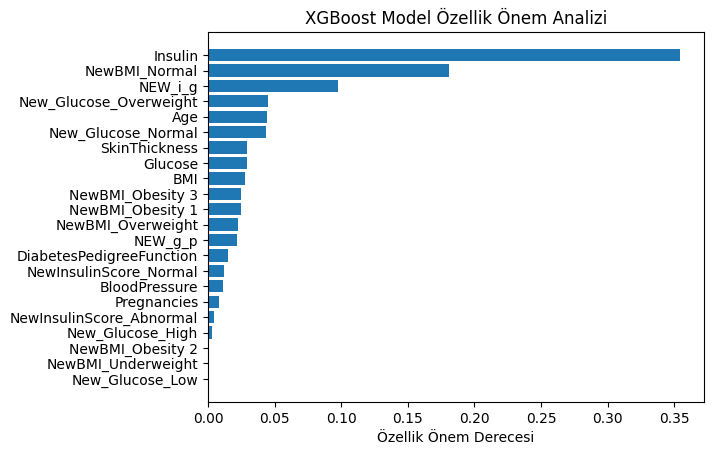

In [35]:
# Özelliklerin önem derecelerini görelim
importances = xgb_tuned.feature_importances_

features = X.columns

sorted_idx = importances.argsort() # Önem derece sıralaması

plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel('Özellik Önem Derecesi')
plt.title('XGBoost Model Özellik Önem Analizi')
plt.show()
